In [89]:
%matplotlib inline

from utils import list_data_files

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

import statsmodels.api as sm
import statsmodels.formula.api as smf

**Table of contents**<a id='toc0_'></a>    
- [Report 1: City level analysis](#toc1_)    
  - [Step 1: Exploratory Data Analysis](#toc1_1_)    
    - [Step 1.a : Univariate Analysis](#toc1_1_1_)    
    - [Step 1.b : Target vs Main Explanatory variable](#toc1_1_2_)    
    - [Step 1.c : Target vs Secondary Explanatory variables](#toc1_1_3_)    
    - [Step 4.d : Correlation Analysis](#toc1_1_4_)    
  - [Step 2: Modeling](#toc1_2_)    
    - [Step 2.a : Choose the model (Poission regression)](#toc1_2_1_)    
    - [Step 2.b : Compare models](#toc1_2_2_)    
    - [Step 2.c : Report finding](#toc1_2_3_)    
    - [d Comparing the models with all the variabel withouth policy_number and with policy_number as a cluster](#toc1_2_4_)    
    - [Step 2.e Conclusion](#toc1_2_5_)    
    - [Step 2.f Explainability of the model](#toc1_2_6_)    
    - [Step 2.h Model Evaluation](#toc1_2_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [ ]:
# Prin the list of data files
list_data_files()

In [90]:
##
## Step 1: Load the data
##

# feature tables
city_comp_df = pd.read_parquet('..\\data\\feature_store\\city_comp_df.parquet')
icd_lookup = pd.read_csv('..\\data\\lookup\\icd_lookup.csv')

In [ ]:
# print the icd_code lookup table
display(icd_lookup[~icd_lookup['icd_code'].str.contains('\.') & icd_lookup['icd_code'].str.contains('E')].sort_values('icd_code'))

## <a id='toc1_1_'></a>[Step 1: Exploratory Data Analysis](#toc0_)
### <a id='toc1_1_1_'></a>[Step 1.a : Univariate Analysis](#toc0_)


In [ ]:
city_comp_df.info()

In [94]:
# Plot the distribution of the diabetes type
numeric_vars  = ['age', 'max_bmi','total_dm_icd', 'total_complications', 'total_comorbidities']
categorical_vars = ['max_major_city', 'age_cat', 'max_bmi_cat', 'total_dm_icd', 'total_complications', 'total_comorbidities']

plot_titles = {
    'age': 'Age Distribution',
    'age_cat': 'Age Category Distribution',
    'max_bmi': 'BMI Distribution',
    'max_bmi_cat': 'BMI Category Distribution',
    'total_complications': 'Total Complications Distribution',
    'total_comorbidities': 'Number of Comorbidities Distribution',
    'total_dm_icd': 'Total Number of Diabetes Reported Distribution',
    'gender': 'Gender Distribution',
    'max_major_city': 'City Distribution'
}

# Set the theme for Seaborn plots
sns.set_theme(style='whitegrid', palette='deep', font='Arial', context='notebook')


In [95]:
def generate_numeric_summary(df, numeric_vars):
    """
    Generate summary statistics for numeric variables from a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    numeric_vars (list): The list of numeric variables to generate summary statistics for.

    Returns:
    pd.DataFrame: The summary statistics DataFrame for numeric variables.
    """
    numeric_summary_df = df[numeric_vars].describe().transpose()
    numeric_summary_df.reset_index(inplace=True)
    numeric_summary_df.rename(columns={'index': 'Variable'}, inplace=True)
    numeric_summary_df = numeric_summary_df.round(2)
    
    return numeric_summary_df

def generate_categorical_summary(df, categorical_vars):
    """
    Generate summary statistics for categorical variables from a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    categorical_vars (list): The list of categorical variables to generate summary statistics for.

    Returns:
    pd.DataFrame: The summary statistics DataFrame for categorical variables.
    """
    categorical_summary_list = []
    for var in categorical_vars:
        counts = df[var].value_counts()
        percentages = df[var].value_counts(normalize=True) * 100
        summary_df = pd.DataFrame({var: counts.index, 'Count': counts.values, 'Percentage': percentages.values})
        summary_df = summary_df.round(2)
        categorical_summary_list.append(summary_df)
    categorical_summary_df = pd.concat(categorical_summary_list, axis=0).reset_index(drop=True)
    
    return categorical_summary_df

def plot_numeric_variables(df, numeric_vars, plot_titles):
    """
    Create plots for numeric variables with custom titles.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    numeric_vars (list): The list of numeric variables to plot.
    plot_titles (dict): A dictionary with variable names as keys and custom plot titles as values.
    """
    for var in numeric_vars:
        plt.figure(figsize = (10, 5))
        sns.histplot(df[var], kde=True)
        plt.title(plot_titles.get(var, var))
        plt.xlabel(var)
        plt.ylabel('Frequency')
        
        # Check if the variable is numeric
        if pd.api.types.is_numeric_dtype(df[var]):
            # Increase the frequency of tick marks on the x-axis with integer steps
            max_value = int(df[var].max())
            min_value = int(df[var].min())
            tick_frequency = max(1, (max_value - min_value) // 10)  # Ensure at least a step of 1
            plt.xticks(np.arange(min_value, max_value + tick_frequency, tick_frequency))
        
        plt.show()

def plot_categorical_variables(df, categorical_vars, plot_titles):
    """
    Create plots for categorical variables with custom titles.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    categorical_vars (list): The list of categorical variables to plot.
    plot_titles (dict): A dictionary with variable names as keys and custom plot titles as values.
    """
    for var in categorical_vars:
        plt.figure(figsize = (10, 5))
        sns.countplot(x=var, data=df)
        plt.title(plot_titles.get(var, var))
        plt.xlabel(var)
        plt.ylabel('Count')
        plt.show()


In [ ]:
city_comp_df

In [ ]:
# print summary statistics
numeric_summary = generate_numeric_summary(city_comp_df, numeric_vars)
categorical_summary = generate_categorical_summary(city_comp_df, categorical_vars)

display("Numeric Summary Statistics:")
display(numeric_summary)
display("\nCategorical Summary Statistics:")
display(categorical_summary[['max_major_city','Count', 'Percentage']].dropna())
display(categorical_summary[['age_cat','Count', 'Percentage']].dropna())
display(categorical_summary[['max_bmi_cat','Count', 'Percentage']].dropna())
display(categorical_summary[['total_dm_icd','Count', 'Percentage']].dropna())
display(categorical_summary[['total_complications','Count', 'Percentage']].dropna())
display(categorical_summary[['total_comorbidities','Count', 'Percentage']].dropna())

In [ ]:
# plot distributions of numeric and categorical variables
plot_numeric_variables(city_comp_df, numeric_vars, plot_titles)
plot_categorical_variables(city_comp_df, categorical_vars, plot_titles)


### <a id='toc1_1_4_'></a>[Step 1.b : Correlation Analysis](#toc0_)

Conduct correlation analysis across all variables

In [ ]:


# Select only numeric columns for correlation analysis
numeric_df = city_comp_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Add title and labels
plt.title('Correlation Matrix')
plt.show()


### <a id='toc1_1_2_'></a>[Step 1.c : Target vs Main Explanatory variable](#toc0_)

Explore the relationship between Target var and main explanatory of city individualy and across other vars


In [ ]:

other_vars = ['gender',  'max_bmi_cat','total_comorbidities', 'total_dm_icd']

for var in other_vars:
    # plt.figure(figsize = (20, 5))
    # sns.boxenplot(x = 'max_major_city', y = 'total_complications', hue= var, data = city_comp_df)
    # plt.title(f'Box plot of total complications and city by {var}')
    # plt.xticks(rotation = 90)
    plt.show()
    plt.figure(figsize = (10, 5))
    sns.violinplot(x = 'max_major_city', y = 'total_complications', hue= var, data = city_comp_df)
    plt.title(f'Violin plot of total complications and city by {var}')
    plt.show()
   

### <a id='toc1_1_3_'></a>[Step 1.d : Target vs Secondary Explanatory variables](#toc0_)

Explore the relationship between outcome var and other explanatory vars


In [ ]:
##
## Step 1: Exploratory Data Analysis
## Step 1.c : Explore the relationship between outcome var and other explanatory vars
##

other_vars = ['gender',  'max_bmi_cat','total_comorbidities', 'total_dm_icd']

for var in other_vars:
    # plt.figure(figsize = (20, 5))
    # sns.boxenplot(x = 'max_major_city', y = 'total_complications', hue= var, data = city_comp_df)
    # plt.title(f'Box plot of total complications and city by {var}')
    # plt.xticks(rotation = 90)
    plt.show()
    plt.figure(figsize = (15, 5))
    sns.boxplot(x = var, y = 'total_complications',  data = city_comp_df)
    plt.title(f'Violin plot of total complications and  {var}')
    plt.show()


# an association is clear between the total complications and the total number of diabetes types reported (total_dm_icd)
# - either the diagnosis is not clear (?) <--> poor care 
# - poor care
# - Other reasons


In [ ]:
city_comp_df[city_comp_df['total_dm_icd']== 4]

## <a id='toc1_2_'></a>[Step 2: Modeling](#toc0_)


### <a id='toc1_2_1_'></a>[Step 2.a : Choose the model (Poission regression)](#toc0_)


In [ ]:
city_comp_df.columns

In [115]:
# Calculate mean and variance of the outcome variable
mean = city_comp_df['total_complications'].mean()
variance = city_comp_df['total_complications'].var()

# Calculate dispersion statistic
dispersion_statistic = variance / mean
print(f"Dispersion Statistic: {dispersion_statistic}")

Dispersion Statistic: 1.5641748509052147


In [ ]:
## Checkin the assumptions for a Poisson regression

# Check for overdispersion
import statsmodels.api as sm
import numpy as np


# Ensure that categorical variables are properly specified
categorical_vars = [ 'age_cat', 'gender', 'max_bmi_cat', 'max_major_city']
for var in categorical_vars:
    city_comp_df[var] = city_comp_df[var].astype('category')


# Define your desired reference city for the categorical variable max_major_city.
# Replace 'CityName' with the actual city you want as the intercept (baseline) category.
reference_city = 'Riyadh'  # e.g., 'New York' or whichever city you prefer

# ------------------------------
# Test 1: Only City as a Categorical Variable
# ------------------------------

formula = (
    'total_complications ~ C(max_major_city, Treatment(reference="%s"))'
    % reference_city
)

# Fit the Poisson regression model and compute clustered standard errors by policy_number.
poisson_uni_model = smf.glm(
    formula=formula,
    data=city_comp_df,
    family=sm.families.Poisson()
).fit()

# Print the summary of the model.
print("\n=== Poisson Regression with only main explanatory variable ===")
print(poisson_uni_model.summary())




# Check the Pearson chi-squared statistic
pearson_chi2 = np.sum((poisson_uni_model.resid_pearson) ** 2)
dof = poisson_uni_model.df_resid  # Degrees of freedom

# Overdispersion test
overdispersion = pearson_chi2 / dof

# Check the result
if overdispersion > 1:
    print(f"Overdispersion detected: {overdispersion}")
else:
    print("No overdispersion detected")


In [ ]:
# since there is overdispersion, we will use a negative binomial regression model

# Fit a Negative Binomial regression model to account for overdispersion
neg_binom_model = smf.glm(
    formula=formula,
    data=city_comp_df,
    family=sm.families.NegativeBinomial()
).fit()

# Print the summary of the model.
print("\n=== Negative Binomial Regression with only main explanatory variable ===")
print(neg_binom_model.summary())


# Fit Poisson regression model with robust standard errors
poisson_model_robust = smf.glm(
    formula=formula,
    data=city_comp_df,
    family=sm.families.Poisson()
).fit(cov_type='HC0')  # HC0 for robust standard errors

# Print the summary of the model
print("\n=== Poisson Regression with Robust Standard Errors ===")
print(poisson_model_robust.summary())



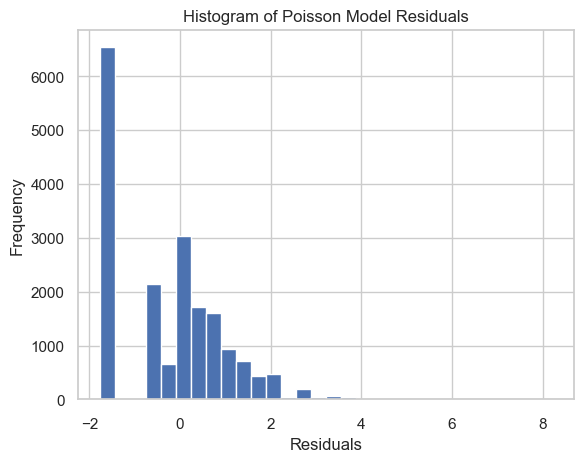

In [ ]:
import matplotlib.pyplot as plt

# Plot residuals of the Poisson model
residuals = poisson_model_robust.resid_deviance
plt.hist(residuals, bins=30)
plt.title("Histogram of Poisson Model Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# This shows heavy overdispersion

In [113]:
# comparing the models

# Deviance, AIC, and BIC comparison between Poisson and Negative Binomial models
print("\nPoisson Regression with Robust Standard Errors")
print(f"Deviance: {poisson_model_robust.deviance}")
print(f"AIC: {poisson_model_robust.aic}")
print(f"BIC: {poisson_model_robust.bic}")

print("\nNegative Binomial Regression")
print(f"Deviance: {neg_binom_model.deviance}")
print(f"AIC: {neg_binom_model.aic}")
print(f"BIC: {neg_binom_model.bic}")


# The Negative Binomial regression model has a lower AIC and BIC compared to the Poisson regression model with robust standard errors.



Poisson Regression with Robust Standard Errors
Deviance: 28567.732939730056
AIC: 58476.656310385064
BIC: -155246.64821590635

Negative Binomial Regression
Deviance: 14753.90956526453
AIC: 58186.45127064178
BIC: -169060.47159037186


c:\Users\Raed\anaconda3\envs\lean_env\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


In [ ]:
##
## Step 2: Modeling
## Step 2.a : Choose the model (Poission regression) 
##


# Ensure that categorical variables are properly specified
categorical_vars = [ 'age_cat', 'gender', 'max_bmi_cat', 'max_major_city']
for var in categorical_vars:
    city_comp_df[var] = city_comp_df[var].astype('category')


# Define your desired reference city for the categorical variable max_major_city.
# Replace 'CityName' with the actual city you want as the intercept (baseline) category.
reference_city = 'Riyadh'  # e.g., 'New York' or whichever city you prefer

# ------------------------------
# Test 1: Only City as a Categorical Variable
# ------------------------------

formula = (
    'total_complications ~ C(max_major_city, Treatment(reference="%s"))'
    % reference_city
)

# Fit the Poisson regression model and compute clustered standard errors by policy_number.
poisson_uni_model = smf.glm(
    formula=formula,
    data=city_comp_df,
    family=sm.families.Poisson()
).fit()

# Print the summary of the model.
print("\n=== Poisson Regression with only main explanatory variable ===")
print(poisson_uni_model.summary())


# ------------------------------
# Test 2: Only City as a Categorical Variable
# ------------------------------

formula = (
    'total_complications ~ C(max_major_city, Treatment(reference="%s")) +  age + C(gender) + max_bmi'
    % reference_city
)

# Fit the Poisson regression model and compute clustered standard errors by policy_number.
poisson_main_model = smf.glm(
    formula=formula,
    data=city_comp_df,
    family=sm.families.Poisson()
).fit()

# Print the summary of the model.
print("\n=== Poisson Regression with only main explanatory variable ===")
print(poisson_main_model.summary())


# ------------------------------
# Test 3: All Explanatory Variables
# Option 1: Exclude policy_number from the model
# ------------------------------

formula_full_without_policy = (
    'total_complications ~ C(max_major_city, Treatment(reference="%s")) + age + C(gender) + max_bmi + total_comorbidities + total_dm_icd'
    % reference_city
)

model_without_policy = smf.glm(
    formula=formula_full_without_policy,
    data=city_comp_df,
    family=sm.families.Poisson()
).fit()

print("\n=== Poisson Regression without policy_number ===")
print(model_without_policy.summary())


# ------------------------------
# Test 3: All Explanatory Variables
# Option 2: Include policy_number (even though it's high-cardinality)
# ------------------------------

formula_full_with_policy = (
    'total_complications ~ C(max_major_city, Treatment(reference="%s"))  + age + C(gender) + max_bmi + total_comorbidities + total_dm_icd'
    % reference_city
)

# Fit the Poisson regression model and compute clustered standard errors by policy_number.
poisson_cluster_model = smf.glm(
    formula=formula_full_with_policy,
    data=city_comp_df,
    family=sm.families.Poisson()
).fit(cov_type='cluster', cov_kwds={'groups': city_comp_df['policy_number']})

# Print the summary of the model.
print("\n=== Poisson Regression with policy_number for clustered standard errors ===")
print(poisson_cluster_model.summary())


# -----------------------------------------------------------------------------
# Description:
#
# In these two options, we're fitting Poisson regression models to assess the impact of
# including versus excluding a high-cardinality variable ('policy_number').
#
# Option 1 includes 'policy_number' as a categorical predictor.
#   - Note: Including it may lead to numerical issues or overparameterization because there are 3391 levels.
#
# Option 2 omits 'policy_number' entirely, simplifying the model.
#
# For both models, the categorical variable 'max_major_city' is explicitly set to use a specific
# city (defined by 'reference_city') as the reference category (i.e., the intercept).
#
# By comparing the summaries (coefficients, standard errors, and goodness-of-fit metrics) of the two models,
# you can evaluate whether including 'policy_number' substantially affects your results.
# -----------------------------------------------------------------------------


In [ ]:
poisson_uni_model.summary()


### <a id='toc1_2_2_'></a>[Step 2.b : Compare models](#toc0_)
 
"Univariable": poisson_uni_model,
"Main": poisson_main_model,
"Without Policy": model_without_policy,
"Clustered": poisson_cluster_model,

In [ ]:
from statsmodels.iolib.summary2 import summary_col

# Assume you have already fitted your four models and saved them as follows:
# 1. poisson_cluster_model: Poisson regression with clustered SEs by policy_number.
# 2. model_without_policy: Poisson regression excluding the policy_number variable.
# 3. univariable_model: Poisson regression with only the main explanatory variable.
# 4. (Optional) model_with_policy_fixed: Poisson regression including policy_number as a fixed effect.
#
# For this example, if you don't have a fourth model (because including policy_number as a fixed effect
# caused convergence issues), simply compile the three models. If you do have it, add it to the dictionary.

# Example dictionary of models:
models = {
    "Univariable": poisson_uni_model,
    "Main": poisson_main_model,
    "Without Policy": model_without_policy,
    "Clustered": poisson_cluster_model,
}

# Define the information dictionary with custom statistics.
info_dict = {
    "N": lambda x: f"{int(x.nobs)}",
    "Pseudo R2": lambda x: f"{x.pseudo_rsquared(kind='cs'):.3f}"
}
# Create a summary table using summary_col
results_table = summary_col(
    list(models.values()),
    model_names=list(models.keys()),
    stars=True,
    info_dict=info_dict,
    float_format="%.3f"
)

print(results_table)

"""
Description:
------------
The code above creates a consolidated report table of your Poisson regression models using
statsmodels' `summary_col` function. The table includes:

- Coefficient estimates, standard errors, z-values, and significance stars.
- Additional model diagnostics (number of observations and pseudo R-squared).
- Four models are compared:
    1. 'Clustered': A full model with clustered standard errors by policy_number.
    2. 'Without Policy': A full model excluding the high-cardinality policy_number variable.
    3. 'Univariable': A model with only the main explanatory variable (max_major_city).
    4. 'With Policy Fixed': (Optional) A model including policy_number as a fixed effect.
    
Reviewing this table helps assess how model specification (particularly regarding the treatment of policy_number)
affects your coefficient estimates and inference.
"""


### <a id='toc1_2_3_'></a>[Step 2.c : Report finding](#toc0_)

Your summary table neatly compares four models:

1. **Univariable**: 
   - Only includes the main explanatory variable (max_major_city).
   - Pseudo R² is 0.033, meaning that this variable explains about 3.3% of the variation in total complications.

2. **Main**: 
   - Includes the full set of covariates (city, age, gender, max_bmi, total_comorbidities, total_dm_icd).
   - Pseudo R² is 0.062, indicating a modest improvement in explained variation when adding these predictors.

3. **Without Policy**: 
   - Excludes the high-cardinality variable policy_number entirely.
   - Pseudo R² jumps to 0.317, suggesting that the model with these covariates explains roughly 31.7% of the variation in complications.

4. **Clustered**: 
   - Uses clustered standard errors by policy_number (without including it as a fixed effect).
   - Also has a Pseudo R² of 0.317. 
   - Note that although the point estimates remain identical to the "Without Policy" model, the standard errors are larger in some cases (e.g., for T.Jeddah, the SE increases from 0.017 to 0.071), leading to more conservative inference.

**Key takeaways:**
- **Coefficient Estimates**: The estimated effects (e.g., for cities) are similar across models.
- **Standard Errors and Significance**: Clustering (Clustered model) increases standard errors, which can affect the statistical significance of some predictors (e.g., T.Jeddah becomes marginally significant).
- **Pseudo R²**: Adding more covariates dramatically improves the model’s fit from 3.3% (Univariable) to 31.7% (Without Policy / Clustered).

Overall, these results support using the robust (Clustered) model because it adjusts for intra-policy correlation, providing more reliable standard errors and inference.



This univariable Poisson regression model examines the association between the city
(where the patient lives, as defined by 'max_major_city') and the count of reported
diabetes complications ('total_complications'). The categorical variable 'max_major_city'
is set with "Riyadh" as the reference (baseline) category.

Key Points from the Results:
- **Intercept:** The intercept is 0.0828, which is the expected log count of complications for patients
  in Riyadh.
- **City Effects (compared to Riyadh):**
  - **Alkhobar:** Coefficient = 0.2308  
    - IRR = exp(0.2308) ≈ 1.259  
    - Interpretation: Patients in Alkhobar have an expected complication count that is approximately 26% higher than those in Riyadh.
  - **Jeddah:** Coefficient = 0.3482  
    - IRR = exp(0.3482) ≈ 1.416  
    - Interpretation: Patients in Jeddah have an expected complication count about 42% higher than those in Riyadh.
  - **Madina:** Coefficient = 0.1207  
    - IRR = exp(0.1207) ≈ 1.128  
    - Interpretation: Patients in Madina have an expected complication count about 13% higher than those in Riyadh.
  - **Makkah:** Coefficient = 0.2639  
    - IRR = exp(0.2639) ≈ 1.302  
    - Interpretation: Patients in Makkah have an expected complication count about 30% higher than those in Riyadh.
  - **Other:** Coefficient = 0.0053  
    - IRR = exp(0.0053) ≈ 1.005  
    - Interpretation: Patients in the 'Other' category show virtually no difference in complication count compared to Riyadh.
    
- **Model Fit:**  
  The pseudo R-squared (CS) is 0.03338, which suggests that the city variable alone explains
  roughly 3.3% of the variation in the count of diabetes complications. This indicates that while
  there are statistically significant differences across cities, a large proportion of the variability
  is likely due to other factors not included in this simple model.

In summary, these results provide initial evidence of geographic differences in diabetes complications.
However, given the modest pseudo R-squared value, further analyses incorporating additional covariates
(e.g., demographic, clinical factors) would be necessary to better understand the drivers of complication counts.

### <a id='toc1_2_4_'></a>[d Comparing the models with all the variabel withouth policy_number and with policy_number as a cluster](#toc0_)

Both models yield identical coefficient estimates because the clustering adjustment only affects
the estimation of the standard errors, not the point estimates. However, you'll notice that the
standard errors are substantially larger in the model with clustered standard errors by policy_number.

For example:
- The standard error for 'C(max_major_city)[T.Jeddah]' increases from 0.017 in the non-clustered model 
    to 0.071 in the clustered model. Consequently, the z-value drops (from 7.813 to 1.854) and the p-value
    rises from 0.000 to 0.064.

- Similarly, for 'total_comorbidities' and 'total_dm_icd', the standard errors are notably higher in the
    clustered model, which affects their z-statistics and the strength of evidence for significance.

These differences indicate that there is non-negligible within-policy correlation (i.e., observations within 
the same policy_number are correlated). The standard (nonrobust) model underestimates the variability of the 
estimates by ignoring this clustering. In contrast, the clustered standard errors provide a more accurate 
reflection of the uncertainty by adjusting for the intra-cluster correlation.

In summary, while the effect estimates are the same, the inference changes:
- The clustered model leads to more conservative (i.e., larger) standard errors.
- Some predictors that appear statistically significant without clustering may become marginally 
    or non-significant when clustering is accounted for.

This highlights the importance of using clustered standard errors when the data exhibit grouping (e.g., 
by policy_number) to avoid overstating the precision of the estimates.

### <a id='toc1_2_5_'></a>[Step 2.e Conclusion](#toc0_)

The more robust model (Option 1), which computes clustered standard errors by policy_number, is preferable.
Although both models produce identical coefficient estimates, the clustered model yields larger (and thus more 
realistic) standard errors by accounting for intra-policy correlation. This leads to more conservative inference, 
ensuring that any within-group dependencies are properly handled.

Therefore, based on the results, it is advisable to use the robust model (Option 1) that adjusts for clustering.

### <a id='toc1_2_6_'></a>[Step 2.f Explainability of the model](#toc0_)

Our robust Poisson regression model examines whether the city in which a patient lives is associated with the count of diabetes complications, while adjusting for important confounders such as age, gender, BMI, total comorbidities, and total diabetes ICD codes. Riyadh is used as the reference city.

Here’s what the model tells us about the association between city and complication count:

1. **Alkhobar:**  
   - **Coefficient:** 0.237  
   - **Interpretation:** Patients living in Alkhobar have an expected log complication count that is 0.237 units higher than those in Riyadh. Converting this to a percentage, exp(0.237) ≈ 1.27, which means there is approximately a 27% higher expected complication count compared to Riyadh.
   - **Significance:** This result is statistically significant.

2. **Makkah:**  
   - **Coefficient:** 0.194  
   - **Interpretation:** Patients in Makkah have an expected log complication count 0.194 units higher than those in Riyadh. This corresponds to exp(0.194) ≈ 1.21, or about a 21% higher expected count.
   - **Significance:** This result is also statistically significant.

3. **Jeddah:**  
   - **Coefficient:** 0.132  
   - **Interpretation:** Patients in Jeddah show a coefficient suggesting an increase of about 0.132 units in the log complication count compared to Riyadh. This translates to exp(0.132) ≈ 1.14, or roughly a 14% higher expected count.
   - **Significance:** However, this association is only marginally significant (with a p-value near 0.064), indicating that the evidence for an association in Jeddah is weaker.

4. **Madina and Other:**  
   - **Coefficients:** Very close to zero (−0.002 for Madina and −0.017 for Other)
   - **Interpretation:** There is no meaningful difference in the expected complication count for patients in Madina or Other cities compared to Riyadh.
   - **Significance:** These differences are not statistically significant.

**Summary:**  
After adjusting for potential confounders, the robust model suggests that living in Alkhobar or Makkah is associated with a significantly higher number of diabetes complications compared to living in Riyadh. The effect for Jeddah points in the same direction (a higher complication count) but is less statistically robust, while no significant differences are observed for patients in Madina or Other cities.

In plain terms, the model provides evidence that, after accounting for various patient characteristics, the city of residence does matter—with certain cities (particularly Alkhobar and Makkah) linked to higher complication counts relative to Riyadh.


======

The robust (Clustered) model is a Poisson regression that adjusts for the fact that observations within the same insurance policy (policy_number) might be more similar to each other than to observations from different policies. Here’s what that means in plain language:

1. **Why Cluster?**  
   - In our data, each patient is associated with a policy number, and there are 3391 unique policies. Patients under the same policy may share unobserved characteristics (like similar healthcare access or plan benefits) that could affect the number of diabetes complications they experience.
   - If we ignore these within-policy similarities, our model might underestimate the uncertainty (i.e., the standard errors) of the estimated effects. This could lead to overly optimistic conclusions about the significance of our predictors.

2. **How the Robust Model Works:**  
   - Instead of including the policy number as a predictor (which would add thousands of dummy variables and create numerical issues), we exclude it from the fixed-effects part of the model.
   - We then account for the clustering of observations by policy number when calculating the standard errors. This is done by computing “clustered standard errors,” which are typically larger than the usual (nonrobust) standard errors because they acknowledge that patients within the same policy are not fully independent.

3. **What the Results Tell Us:**  
   - The point estimates (the coefficients) remain almost the same whether or not we cluster by policy number. This indicates that the overall estimated effects (for example, the effect of living in Jeddah versus Riyadh) are robust.
   - However, the standard errors in the robust model are larger. For instance, the effect for Jeddah shows a higher standard error in the clustered model, which means we are less confident about the precision of this estimate. Consequently, some predictors might be less statistically significant once we properly account for the clustering.
   - The pseudo R² (a measure of how well the model explains the variability in the outcome) remains the same because it’s based on the model’s coefficients and log-likelihood, not on the standard errors.

4. **In Summary:**  
   The robust model (with clustered standard errors by policy_number) is preferred because it provides a more realistic measure of uncertainty by considering the similarities among patients within the same policy. Even though the estimated effects (coefficients) are similar to those from the simpler model, the robust model gives more conservative (and trustworthy) standard errors, leading to better-informed statistical inferences.

This approach ensures that our conclusions about the relationships between predictors (like the city of residence) and the count of diabetes complications are more reliable, especially when data are grouped in a meaningful way.


### <a id='toc1_2_7_'></a>[Step 2.h Model Evaluation](#toc0_)

In [ ]:


# Example dictionary of models:
models = {
    "Univariable": poisson_uni_model,
    "Main": poisson_main_model,
    "Without Policy": model_without_policy,
    "Clustered": poisson_cluster_model,
}

# Additional Checks:
# - Ensure that the outcome is count data and non-negative.
# - Consider plotting the distribution of total_complications.
plt.figure(figsize=(8, 5))
plt.hist(city_comp_df['total_complications'], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel("Total Complications")
plt.ylabel("Frequency")
plt.title("Distribution of Total Complications")
plt.show()

for model_name, model in models.items():

    print(f"\n=== Diagnostic Plots for {model_name} Model ===")
    # 1. Check for overdispersion:
    # Calculate the Pearson chi-square statistic and compare it to the degrees of freedom.
    pearson_chi2 = sum(model.resid_pearson**2)
    df_resid = model.df_resid
    dispersion = pearson_chi2 / df_resid
    print("Pearson Chi2 / Degrees of Freedom:", dispersion)
    # A value substantially greater than 1 indicates overdispersion.

    # 2. Plot deviance residuals vs. fitted values to assess the model fit and potential non-linearity:
    plt.figure(figsize=(8, 5))
    plt.scatter(model.fittedvalues, model.resid_deviance, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Fitted values")
    plt.ylabel("Deviance Residuals")
    plt.title("Deviance Residuals vs. Fitted Values")
    plt.show()

    # 3. Q-Q plot of the deviance residuals:
    sm.qqplot(model.resid_deviance, line='45', fit=True)
    plt.title("Q-Q Plot of Deviance Residuals")
    plt.show()


    print(f"\n=== END  of {model_name} Model ===")

    # Note:
    # While these diagnostic plots help evaluate the fit of the Poisson model,
    # they do not check all assumptions (e.g., independence of observations).
    # The overdispersion check (dispersion >> 1) is particularly important;
    # if overdispersion is present, consider using a Negative Binomial model.
